Data preprocessing and initial testing for the CDC webscraping project. The focus of my work is on utilizing multi-modal vision-language models to automatically detect certain marketing features present in vape advertisements. I am beginning by focusing on "iced" flavor vapes as this flavoring can be signaled by the name of the vape, the description, the image, or all. 

VLMs are an attractive approach for 2 reasons:
1). This problem is inherently multi-modal, and although it may be easy to extract this information from text data, it might be more difficult to extract if present in the images but not the text
2). Most of these models are very strong zero/few-shot learners. So, we may be able to hand label only a small collection of these image-text pairs and gain good performance.

Here are some reference papers:

CLIP: https://arxiv.org/abs/2103.00020 

FLAVA:https://arxiv.org/abs/2112.04482

In [1]:
import pandas as pd
import numpy as np
import os
import torch
print(torch.cuda.is_available())

True


In [4]:
os.getcwd()
text_data = pd.read_csv("../../mipod_data/mipod.csv")

In [5]:
print(text_data.Description.isna().sum())
print(len(text_data))
print(text_data.description.isna().sum())
print(text_data.Flavor.isna().sum())

1032
1053
954
120


In [6]:
text = {}
#generate our text by concatenating all text data we have available together.
#for the vast majority of entries, this comes from only the "Flavor" column.
for i in range(len(text_data)):
    curr = text_data.iloc[i,:]
    name = curr.Product
    desc = ""
    if not pd.isna(curr.Description):
        desc += curr.Description
    if not pd.isna(curr.description):
        desc += curr.description
    if not pd.isna(curr.Flavor):
        desc += curr.Flavor
    if desc == "":
        continue
    idx = desc.find("\"category\"")
    if idx == -1:
        text[name] = desc
        continue
    text[name] = desc[:idx]

In [1]:
%reload_ext autoreload
%autoreload 2
from utils import get_imgs
img = get_img("/mipod_data/mipod_imgs", list(data.keys())[0])
plt.imshow(img)

ImportError: cannot import name 'get_img' from 'utils' (/home/jwessell6/CDCF_Webscrapping_Vape_Products_Project/testing/utils.py)

In [6]:
files = os.listdir("../../mipod_data/mipod_imgs")

In [9]:
from PIL import Image
imgs = {}
#match the text to the image.
for key in data.keys():
    name = key + ".jpg"
    for file in files:
        if name in file:
            image = Image.open('../../mipod_data/mipod_imgs' + '/' + file).convert('RGB')
            image = image.resize((256,256),Image.LANCZOS)
            imgs[key] = image

NameError: name 'data' is not defined

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F23F9A9E0>


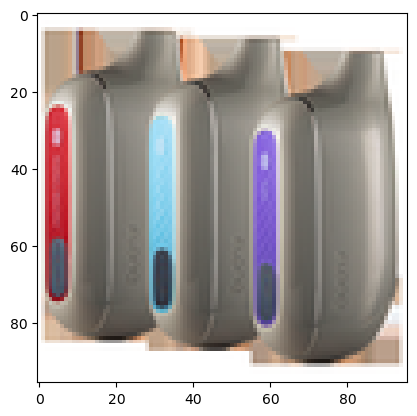

In [19]:
import matplotlib.pyplot as plt
print(imgs['Flonq Max Smart Fruity Fusion 2% Sampler'])
plt.imshow(imgs['Flonq Max Smart Fruity Fusion 2% Sampler'])

In [1]:
%reload_ext autoreload
%autoreload 2
from vlm import run_hf
topic = 'screen'
results = run_hf(topic = topic, batch_size = 32)

RuntimeError: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
import pickle
name = "mipod-" + topic + ".pkl"
with open(name, 'wb') as file:
    pickle.dump(results, file)

In [17]:
from transformers import AutoProcessor
processor = AutoProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf", padding_side = 'left')
print(inputs['input_ids'].shape)
print(gen.shape)
print(gen.shape[1] - inputs['input_ids'].shape[1])
tokens = gen[:, -(gen.shape[1] - inputs['input_ids'].shape[1]):]
print(processor.batch_decode(tokens, skip_special_tokens=True, clean_up_tokenization_spaces=False))

torch.Size([1, 624])
torch.Size([1, 629])
5
['No.<\\s>']


In [41]:
import pickle
topic = 'iced'
with open('zeroshot' +topic + '.pkl', 'rb') as file:
    # Load the object from the file
    my_object = pickle.load(file)

In [42]:
with open('../../data/zeroshot.pkl', 'rb') as file:
    descs = pickle.load(file)
print(descs[0])

('vapingdotcom', 'red-bomb-elux-cyberover-18k', 'Desc: ELUX CYBEROVER VAPE\n\nGet ready for an explosion of flavor with Red Bomb ELUX Cyberover 18K, now available at Vaping.com! Experience the quintessential taste of cherry combined with a symphony of delicious red fruit flavors.', '/home/jwessell6/../../projects/frostbyte-1/cdcf_ecig_analysis/box_src/data_from_sites/vapingdotcom/vapingdotcom_images/red-bomb-elux-cyberover-18k_secondary.png')


In [43]:
import pandas as pd
site_name = []
vape_name = []
answer = []
text = []
yes = ['Yes', 'Yes,', 'Yes.', 'yes', 'yes.','yes,']
no = ['No', 'No,','No.' 'yes', 'yes.', 'yes,']
for res in my_object:
    site_name.append(res[0])
    vape_name.append(res[1])
    if res[2][0] in yes:
        answer.append(1)
    elif res[2][0] in no:
        answer.append(0)
    else:
        answer.append(res[2][0])
    for desc in descs:
        if res[1] == desc[1]:
            string = desc[2].replace('\n', '')
            text.append(desc[2])
            break
data = pd.DataFrame(columns = ['site', 'vape', topic, 'desc.'])

In [44]:
print(len(site_name))
print(len(vape_name))
print(len(answer))
print(len(text))

8688
8688
8688
8688


In [45]:
data['site'] = site_name
data['vape'] = vape_name
data[topic] = answer
data['desc.'] = text
data.sort_values(by = 'vape', axis = 0, inplace = True)
data.to_csv('zeroshot-' + topic + '.csv')
#sites with potential flavor lists:
#vapewh: Flavors:

In [1]:
import pandas as pd
from PIL import Image
import numpy as np
import os
image_paths = {
    'csvape' : 'projects/frostbyte-1/cdcf_ecig_analysis/box_src/data_from_sites/csvape/csvape_images',
    'getpop' : 'projects/frostbyte-1/cdcf_ecig_analysis/box_src/data_from_sites/getpop/getpop_images',
    'mipod' : 'projects/frostbyte-1/cdcf_ecig_analysis/box_src/data_from_sites/mipod/images',
    'myvaporstore' : 'projects/frostbyte-1/cdcf_ecig_analysis/box_src/data_from_sites/myvaporstore/myvaporstore_images',
    'perfect_vape' : 'projects/frostbyte-1/cdcf_ecig_analysis/box_src/data_from_sites/perfect_vape/perfectvape_images',
    'vapedotcom' : 'projects/frostbyte-1/cdcf_ecig_analysis/box_src/data_from_sites/vapedotcom/vapedotcom_images',
    'vapesourcing' : 'projects/frostbyte-1/cdcf_ecig_analysis/box_src/data_from_sites/vapesourcing/vapesourcing_images',
    'vapewh' : 'projects/frostbyte-1/cdcf_ecig_analysis/box_src/data_from_sites/vapewh/vapewh_images',
    'vapingdotcom' : 'projects/frostbyte-1/cdcf_ecig_analysis/box_src/data_from_sites/vapingdotcom/vapingdotcom_images'

}
text_paths = {
    'csvape' : 'projects/frostbyte-1/cdcf_ecig_analysis/box_src/data_from_sites/csvape/csvape_scrape.csv',
    'getpop' : 'projects/frostbyte-1/cdcf_ecig_analysis/box_src/data_from_sites/getpop/getpop_ecig.csv',
    'mipod' : 'projects/frostbyte-1/cdcf_ecig_analysis/box_src/data_from_sites/mipod/product_type_mipod.csv',
    'myvaporstore': 'projects/frostbyte-1/cdcf_ecig_analysis/box_src/data_from_sites/myvaporstore/myvaporstore_scrape.csv',
    'perfect_vape' : 'projects/frostbyte-1/cdcf_ecig_analysis/box_src/data_from_sites/perfect_vape/perfectvape_scrape.csv',
    'vapedotcom' : 'projects/frostbyte-1/cdcf_ecig_analysis/box_src/data_from_sites/vapedotcom/vapedotcom_scrape.csv',
    'vapesourcing' : 'projects/frostbyte-1/cdcf_ecig_analysis/box_src/data_from_sites/vapesourcing/vapesourcing_scrape.csv',
    'vapewh' : 'projects/frostbyte-1/cdcf_ecig_analysis/box_src/data_from_sites/vapewh/vapewh_scrape.csv',
    'vapingdotcom' : 'projects/frostbyte-1/cdcf_ecig_analysis/box_src/data_from_sites/vapingdotcom/vapingdotcom_scrape.csv'
}

In [2]:
import pickle
def generate_data(site: str):
    #data will be a list of tuples: the name, an image, and a text description.
    data = []
    path = os.path.expanduser("~") + '/../../'
    text_data = pd.read_csv(path + text_paths[site])
    image_files = os.listdir(path + image_paths[site])
    for i in range(len(text_data)):
        eg = text_data.iloc[i,:]
        text = ""
        name = ""
        if site in ['vapingdotcom','perfect_vape','vapewh', 'vapedotcom', 'vapesourcing']:
            name = eg.tag
            if not pd.isna(eg.description):
                text += "Desc: " + eg.description
            if not pd.isna(eg.flavors_description):
                text += "Flavors: " + eg.flavors_description
            if not pd.isna(eg.key_features_description):
                text += "features: " + eg.key_features_description
            img = False
            for file in image_files:
                if name in file:
                    img = True
                    data.append((site, name,text,path + image_paths[site] + '/' +file)) 
            if not img:
                #won't always have image data
                data.append((site, name,text,""))
                
        if site in['getpop', 'myvaporstore','csvape']:
            name = eg.tag
            if not pd.isna(eg.description):
                text += eg.description
            img = False
            for file in image_files:
                if name in file:
                    img = True
                    data.append((site, name,text, path + image_paths[site] + '/'+ file)) 
            if not img:
                #won't always have image data
                data.append((site, name,text,""))
        if site == 'mipod':
            name = eg.Product
            if not pd.isna(eg.Description):
                text += eg.Description
            text += " Display: "
            if not pd.isna(eg.Display_Description):
                text += eg.Display_Description
            for file in image_files:
                if name in file:
                    img = True
                    data.append((site, name, text,  path + image_paths[site] + '/'+ file)) 
            if not img:
                #won't always have image data
                data.append((site, name,text,""))
    return data

In [3]:
for site in image_paths.keys():
    data = generate_data(site)
    print(len(data))
    name = os.path.expanduser("~") + '/data/' + site + ".pkl"
    with open(name, 'wb') as file:
        pickle.dump(data, file)

710
992
1038
2062
2946
35378
35449
14165
8221


In [9]:
import random
files = os.listdir('../../data')
dataset = []
for file in files:
    with open('../../data/' + file, 'rb') as data:
        lst = pickle.load(data)
        random.shuffle(lst)
        for i in range(min(1000, len(lst))):
            dataset.append(lst[i])
print(len(dataset))
with open('../../data/zeroshot.pkl', 'wb') as file:
        pickle.dump(dataset, file)

8702


In [10]:
with open('../../data/zeroshot.pkl', 'rb') as file:
     data = pickle.load(file)

In [ ]:
from utils import make_prompt
from transformers import AutoProcessor
processor = AutoProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf", padding_side = 'left')
for i in range(32*35, 32*40):
    '''prompt = processor.apply_chat_template([make_prompt(data[i][2], 'iced')], add_generation_prompt=True)
    print(data[i][0])
    print(prompt)
    print(data[i][3])
    print("")'''

In [3]:
from transformers import AutoProcessor, LlavaNextForConditionalGeneration
import torch
model = LlavaNextForConditionalGeneration.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf", torch_dtype=torch.float16, device_map = 'cpu')
processor = AutoProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")

In [10]:
model.config.max_length = 1000
print(model.text_config.model_type)
print(dir(model.config))

AttributeError: 'LlavaNextForConditionalGeneration' object has no attribute 'text_config'